In [11]:
from catboost import CatBoostRegressor, Pool
import pandas as pd
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from sklearn import metrics
import numpy as np

In [12]:
df = pd.read_csv('data/train_new.csv').rename({'target': 'value'}, axis=1)

In [13]:
week_info = df.groupby('Период_неделя')['value'].agg(['sum', 'count'])
week_info.columns = [f'week_{x}' for x in week_info.columns]

In [14]:
df.merge(week_info, how='left', right_index=True, left_on='Период_неделя')

,Период_год,Период_неделя,Период_Начало нед,value,"KPI данные понедельно АлфаРМ_Продажи, упаковки",kpi_продажи_рубли,Раствор_6,Раствор_7,Раствор_8,Раствор_9,...,"Медиа (Конкурент 13)_ТВ, trp(Ж 30-60 ВС)","Медиа (Конкурент 13)_ТВ, охват 5+(Ж 30-60 ВС)","Медиа (Конкурент 13)_ТВ, рубли","Медиа (Конкурент 13)_Диджитал, руб","Медиа (Конкурент 13)_ТВ спонсорство, рубли","Медиа (Конкурент 13)_OOH, рубли","Медиа (Конкурент 13)_Радио, рубли",Медиа (Конкурент 13)_Итого,week_sum,week_count
0,2019.0,1,2018-12-31,4.153557e+07,114621.15,0.0,0.0,0.0,0.0,0.0,...,207.903106,15.3615,9085528.010322582,0.0,0.0,0.0,0.0,9085528.01,2.927774e+08,5
1,NaN,2,2019-01-07,5.122229e+07,141523.20,0.0,0.0,0.0,0.0,0.0,...,317.467542,25.5255,10599782.67870968,0.0,0.0,0.0,0.0,10599782.68,3.131964e+08,5
2,NaN,3,2019-01-14,5.712735e+07,157926.30,0.0,0.0,0.0,0.0,0.0,...,192.816682,13.9125,10599782.67870968,0.0,0.0,0.0,0.0,10599782.68,3.421588e+08,5
3,NaN,4,2019-01-21,6.304099e+07,173746.65,0.0,0.0,0.0,0.0,0.0,...,138.371621,8.0535,10599782.67870968,0.0,0.0,0.0,0.0,10599782.68,3.987940e+08,5
4,NaN,5,2019-01-28,6.733689e+07,185551.80,0.0,0.0,0.0,0.0,0.0,...,286.984113,24.2235,12893092.405548388,0.0,0.0,0.0,0.0,12893092.41,4.246638e+08,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
309,NaN,49,2024-12-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.234709e+08,4
310,NaN,50,2024-12-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.294805e+08,4
311,NaN,51,2024-12-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.138648e+08,4
312,NaN,52,2024-12-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.934011e+08,4


In [15]:
import pandas as pd

def create_features(df):

    week_info = df.groupby('Период_неделя')['value'].agg(['sum', 'count'])
    week_info.columns = [f'week_{x}' for x in week_info.columns]

    df = df.merge(week_info, how='left', right_index=True, left_on='Период_неделя')
    df['week_sum'] -= df['value']
    df['week_count'] -= 1
    df['feature_mean_week'] = df['week_sum'] / df['week_count']
    df['feature_mean_week_norm'] = df['feature_mean_week'] / df['value']


    for i in range(28):
        df[f'target_{i+1}'] = df['value'].shift(-i) / df['value'].shift(1)

    for i in range(1, 8):
        df[f'feature_{i}_weeks_ago'] = df['value'].shift(i) / df['value'].shift(i+1)
    
    for i in [7, 13, 20]:
        df[f'feature_big_diff_{i}_weeks'] = df['value'].shift(1) / df['value'].shift(i)

    bad_cols = [col for col in df.columns if 'feature' not in col and 'target' not in col]
    df.drop(bad_cols, axis=1, inplace=True)
    
    return df

df = create_features(df)
df = df.dropna().reset_index(drop=True)

In [16]:
df

,feature_mean_week,feature_mean_week_norm,target_1,target_2,target_3,target_4,target_5,target_6,target_7,target_8,...,feature_1_weeks_ago,feature_2_weeks_ago,feature_3_weeks_ago,feature_4_weeks_ago,feature_5_weeks_ago,feature_6_weeks_ago,feature_7_weeks_ago,feature_big_diff_7_weeks,feature_big_diff_13_weeks,feature_big_diff_20_weeks
0,5.127196e+07,1.119780,1.008853,1.016405,1.043806,1.048355,1.032292,1.019019,1.011558,1.032917,...,1.067960,0.856883,0.926630,0.954018,1.030047,1.009425,0.981312,0.841145,0.735075,1.092696
1,5.231099e+07,1.133984,1.007486,1.034647,1.039156,1.023233,1.010077,1.002682,1.023853,1.014407,...,1.008853,1.067960,0.856883,0.926630,0.954018,1.030047,1.009425,0.840667,0.742469,0.893898
2,5.456807e+07,1.151859,1.026959,1.031435,1.015631,1.002572,0.995232,1.016245,1.006869,0.987313,...,1.007486,1.008853,1.067960,0.856883,0.926630,0.954018,1.030047,0.822254,0.843151,0.807499
3,5.397206e+07,1.134334,1.004358,0.988969,0.976253,0.969105,0.989567,0.980437,0.961395,0.967376,...,1.026959,1.007486,1.008853,1.067960,0.856883,0.926630,0.954018,0.885121,0.784715,0.751478
4,5.567545e+07,1.188343,0.984677,0.972017,0.964900,0.985273,0.976183,0.957223,0.963178,0.970585,...,1.004358,1.026959,1.007486,1.008853,1.067960,0.856883,0.926630,0.959367,0.824459,0.706602
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191,8.273329e+07,1.219161,1.048548,1.111885,1.138189,1.149585,1.003513,1.045746,0.944308,1.016310,...,0.973701,0.996281,0.822767,0.873839,0.923610,1.039196,1.113352,0.669424,0.896379,0.684062
192,8.817597e+07,1.225348,1.060404,1.085491,1.096359,0.957050,0.997328,0.900586,0.969255,0.927885,...,1.048548,0.973701,0.996281,0.822767,0.873839,0.923610,1.039196,0.675448,0.995743,0.646986
193,8.408086e+07,1.141437,1.023657,1.033906,0.902533,0.940517,0.849286,0.914042,0.875029,0.820863,...,1.060404,1.048548,0.973701,0.996281,0.822767,0.873839,0.923610,0.775488,1.023612,0.766380
194,7.808683e+07,1.049557,1.010012,0.881675,0.918781,0.829658,0.892918,0.854807,0.801893,0.815722,...,1.023657,1.060404,1.048548,0.973701,0.996281,0.822767,0.873839,0.908444,0.982478,0.905731


In [17]:
test_size = 0.4

train_data, valid_data = df[:int(len(df) * (1-test_size))], df[int(len(df) * (1-test_size)):]

all_metrics = []
all_preds = []
for i in range(1, 29):
    print(f'Предсказываение на {i} недель вперед')
    X_train, y_train = train_data.drop([x for x in train_data.columns if 'target' in x], axis=1), train_data[f'target_{i}']
    X_valid, y_valid = valid_data.drop([x for x in valid_data.columns if 'target' in x], axis=1), valid_data[f'target_{i}']


    model = CatBoostRegressor(
        depth=3,
        iterations=3000,
        loss_function='RMSE',
        eval_metric='R2',

        random_state=42,
        thread_count=4,
        early_stopping_rounds=500
    )

    model.fit(X_train, y_train, eval_set=(X_valid, y_valid), verbose=False)

    preds = model.predict(X_valid)
    all_preds.append(preds)

    r2_metric = metrics.r2_score(y_valid, preds)
    mape_metric = metrics.mean_absolute_percentage_error(y_valid, preds)
    all_metrics.append([r2_metric, mape_metric])

    print(f'R2: {round(r2_metric, 5)}')
    print(f'MAPE: {round(mape_metric, 5)}')
    
    print()

Предсказываение на 1 недель вперед
R2: 0.4291
MAPE: 0.05926

Предсказываение на 2 недель вперед
R2: 0.11352
MAPE: 0.12981

Предсказываение на 3 недель вперед
R2: -0.01393
MAPE: 0.17966

Предсказываение на 4 недель вперед
R2: -0.02436
MAPE: 0.21187

Предсказываение на 5 недель вперед
R2: -0.00306
MAPE: 0.22333

Предсказываение на 6 недель вперед
R2: -0.04291
MAPE: 0.24159

Предсказываение на 7 недель вперед
R2: -0.07703
MAPE: 0.24985

Предсказываение на 8 недель вперед
R2: -0.11175
MAPE: 0.26972

Предсказываение на 9 недель вперед
R2: 0.04673
MAPE: 0.25902

Предсказываение на 10 недель вперед
R2: 0.22266
MAPE: 0.23051

Предсказываение на 11 недель вперед
R2: 0.27931
MAPE: 0.22641

Предсказываение на 12 недель вперед
R2: 0.09366
MAPE: 0.30007

Предсказываение на 13 недель вперед
R2: -0.12323
MAPE: 0.34813

Предсказываение на 14 недель вперед
R2: -0.15998
MAPE: 0.36905

Предсказываение на 15 недель вперед
R2: -0.17036
MAPE: 0.3748

Предсказываение на 16 недель вперед
R2: 0.08881
MAPE: 0.2

In [18]:
pd.DataFrame({
    'name': X_train.columns,
    'imp': model.get_feature_importance()
}).sort_values('imp', ascending=False)

,name,imp
11,feature_big_diff_20_weeks,30.401466
0,feature_mean_week,28.272357
1,feature_mean_week_norm,10.943017
9,feature_big_diff_7_weeks,9.452217
10,feature_big_diff_13_weeks,6.274683
7,feature_6_weeks_ago,3.725506
3,feature_2_weeks_ago,3.212083
8,feature_7_weeks_ago,2.284415
4,feature_3_weeks_ago,1.933605
6,feature_5_weeks_ago,1.805647


In [19]:
np.mean([x[0] for x in all_metrics]), np.mean([x[1] for x in all_metrics])

(0.021565583874174104, 0.3057099062226817)

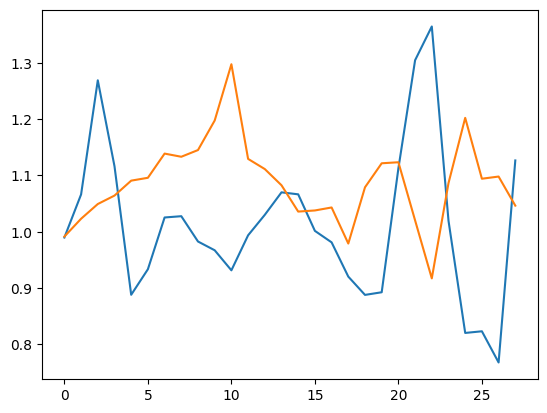

In [20]:
plt.plot(valid_data['target_1'].tolist()[:28])
plt.plot([x[0] for x in all_preds])